In [56]:
import os

import numpy as np
import pandas as pd
from IPython.display import display
from surprise.dump import load

from train import (
    load_dataset, map_users_to_groups, train_agg_models_model, train_agg_predictions_model,
    get_agg_models_file_path, get_agg_predictions_file_path)

In [3]:
SEED = 714
TRAIN_SIZE = 0.75

# Introducción

En este _notebook_ vamos a realizar el entrenamiento de sistemas de recomendación para grupos utilizando las dos estrategias de agregación implementadas en el archivo `train.py`: _Aggregated Models_ y _Aggregated Predictions_.

El conjunto de datos utilizado es el de `MovieLens 100k`:

In [15]:
df = load_dataset()
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Como podemos ver, disponemos de 100836 puntuaciones dadas por usuarios a películas. Podemos también comprobar cuántos usuarios e items (películas) existen en el _dataset_:

In [20]:
len(df['userId'].unique())

610

In [21]:
len(df['movieId'].unique())

9724

Por último, también podemos ver el rango de puntuaciones, así como su distribución:

In [23]:
df['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<Axes: >

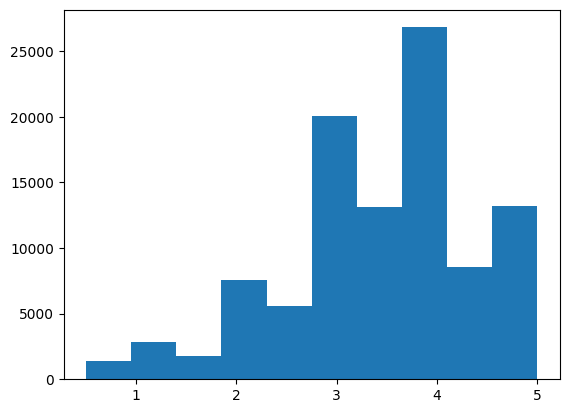

In [27]:
df['rating'].hist(grid=False)

---

# Entrenamiento

## Aggregated Models

En primer lugar, vamos a mostrar cómo se puede ejecutar el entrenamiento desde línea de comandos:

In [10]:
!python ./train.py -a agg-models -r 3.5 -g 10 -m SVD -k 10

Selected approach: Aggregated Models
Training...
Best params: {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}, RMSE score: 0.8789352496982608
Elapsed time: 246.020 seconds
Evaluation of best model on test dataset:
 - RMSE on aggregated group ratings: 0.8706673047957918
 - RMSE on original user ratings: 0.941450418201926
 - Precision@10: 0.8459016393442623
 - Recall@10: 0.08577781914723133
 - Coverage: 1.0
Saving best model...


Sin embargo, en este _notebook_ llamaremos directamente a las funciones que realizan el entrenamiento, pues vamos a modificar el valor de ciertos argumentos como el algoritmo de predicción utilizado, el tamaño del grupo o el umbral de relevancia.

En el caso de la estrategia Aggregated Models, puesto que el paso inicial consiste en agregar las puntuaciones o _ratings_ de los usuarios de cada grupo, sólo será necesario entrenar un nuevo modelo cada vez que cambiemos el tamaño del grupo (pues la partición de entrenamiento siempre será la misma dado que no vamos a modificar el valor por defecto de los parámetros `--train-size` y `--seed`). Por tanto, cuando modifiquemos el valor de otros argumentos que no sean el tamaño del grupo, podremos saltarnos el entrenamiento con el argumento `-n` o `--skip-training` y simplemente evaluar sobre el conjunto de test del mismo _holdout_ con el que se entrenó:

In [3]:
agg_models_results = []
for model_name in ('SVD', 'KNNBaseline'):
    for group_size in (3, 5, 10):
        trained = False
        for relevance_threshold in (3.5, 4.0, 4.5):
            for num_recommended_items in (5, 10):
                print(f'{model_name}, groups of {group_size} users, '
                      f'{relevance_threshold} relevance threshold, '
                      f'{num_recommended_items} recommended items.')
                best_hyperparams, metrics = train_agg_models_model(
                    model_name, TRAIN_SIZE, group_size, num_recommended_items,
                    relevance_threshold, SEED, skip_training=trained)
                result = {
                    'model_name': model_name,
                    'group_size': group_size,
                    'relevance_threshold': relevance_threshold,
                    'num_recommended_items': num_recommended_items,
                    'best_hyperparams': best_hyperparams,
                    **metrics
                }
                agg_models_results.append(result)
                if not trained:
                    trained = True
                print()

SVD, groups of 3 users, 3.5 relevance threshold, 5 recommended items.
Selected approach: Aggregated Models
Training...
Best hyperparams: {'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}, RMSE score: 0.8831452102966753
Elapsed time: 399.328 seconds
Evaluation of best model on test dataset:
 - RMSE on aggregated group ratings: 0.8804339410775935
 - RMSE on original user ratings: 0.9063806168260169
 - Precision@5: 0.8423645320197044
 - Recall@5: 0.13006036241920604
 - Coverage: 1.0
Saving best model...

SVD, groups of 3 users, 3.5 relevance threshold, 10 recommended items.
Selected approach: Aggregated Models
Evaluation of best model on test dataset:
 - RMSE on aggregated group ratings: 0.8804339410775935
 - RMSE on original user ratings: 0.9063806168260169
 - Precision@10: 0.8339901477832513
 - Recall@10: 0.2525460234772488
 - Coverage: 1.0

SVD, groups of 3 users, 4.0 relevance threshold, 5 recommended items.
Selected approach: Aggregated Models
Evaluation of best mode

Podemos cargar los resultados que vemos en la salida de la celda anterior en un `DataFrame`:

In [12]:
df_agg_models_results = pd.DataFrame(agg_models_results)

Veamos la mejor combinación de hiperparámetros para los 6 modelos entrenados:

In [14]:
df_agg_models_results.loc[df_agg_models_results['best_hyperparams'].notnull(), 'best_hyperparams'].values.tolist()

[{'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1},
 {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1},
 {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1},
 {'k': 7,
  'sim_options': {'name': 'pearson_baseline',
   'user_based': True,
   'min_support': 2,
   'shrinkage': 100},
  'bsl_options': {'method': 'als', 'reg_i': 10, 'reg_u': 15, 'n_epochs': 10},
  'verbose': False},
 {'k': 7,
  'sim_options': {'name': 'pearson_baseline',
   'user_based': True,
   'min_support': 10,
   'shrinkage': 100},
  'bsl_options': {'method': 'als', 'reg_i': 10, 'reg_u': 15, 'n_epochs': 10},
  'verbose': False},
 {'k': 7,
  'sim_options': {'name': 'pearson_baseline',
   'user_based': True,
   'min_support': 2,
   'shrinkage': 100},
  'bsl_options': {'method': 'als', 'reg_i': 10, 'reg_u': 15, 'n_epochs': 10},
  'verbose': False}]

Las tres primeras corresponden a `SVD` con un tamaño de grupo de 3, 5 y 10 usuarios, respectivamente. Como podemos ver, para un mayor tamaño de los grupos, un menor número de factores es necesario para obtener los mejores resultados. Esto tiene sentido, puesto que al agregar las puntuaciones de un mayor número de usuarios, el número de grupos obtenidos es menor y por tanto la matriz a factorizar también lo es. 

In [13]:
df_agg_models_results.loc[:, df_agg_models_results.columns != 'best_hyperparams']

,model_name,group_size,relevance_threshold,num_recommended_items,RMSE_group_ratings,RMSE_user_ratings,Precision@k,Recall@k,Coverage
0,SVD,3,3.5,5,0.880434,0.906381,0.842365,0.130060,1.000000
1,SVD,3,3.5,10,0.880434,0.906381,0.833990,0.252546,1.000000
2,SVD,3,4.0,5,0.880434,0.906381,0.747783,0.140250,0.891626
3,SVD,3,4.0,10,0.880434,0.906381,0.723153,0.267688,0.891626
4,SVD,3,4.5,5,0.880434,0.906381,0.437438,0.168461,0.295567
5,SVD,3,4.5,10,0.880434,0.906381,0.414286,0.316811,0.295567
6,SVD,5,3.5,5,0.878092,0.922336,0.832787,0.075748,1.000000
7,SVD,5,3.5,10,0.878092,0.922336,0.831148,0.149481,1.000000
8,SVD,5,4.0,5,0.878092,0.922336,0.729508,0.082495,0.934426
9,SVD,5,4.0,10,0.878092,0.922336,0.724590,0.161111,0.934426


Guardamos estos resultados en un fichero .csv:

In [25]:
df_agg_models_results.to_csv('agg_models_results.csv', index=False)

## Aggregated Predictions

Vamos a proceder de la misma forma que con la estrategia anterior; en primer lugar, el siguiente es un ejemplo de como utilizar el script de entrenamiento desde la línea de comandos:

In [15]:
!python ./train.py -a agg-predictions -r 3.5 -g 10 -m SVD -k 10

Selected approach: Aggregated Predictions
Training...
Best hyperparams: {'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}, RMSE score: 0.8617097713558888
Elapsed time: 498.275 seconds
Evaluation of best model on test dataset:
 - RMSE on original user ratings: 0.8593084736184794
	Strategy: Average
	 - RMSE on aggregated group ratings (Average): 0.8347910057769606
	 - Coverage: 1.0
	 - Precision@10: 0.9278688524590162
	 - Recall@10: 0.07268309696343335

	Strategy: Average Without Misery
	 - RMSE on aggregated group ratings (Average): 0.8299251621971556
	 - Coverage: 1.0
	 - Precision@10: 0.9278688524590162
	 - Recall@10: 0.07348619535267152

	Strategy: Multiplicative
	 - Precision@10: 0.8311475409836063
	 - Recall@10: 0.06505299631534187

	Strategy: Least Misery
	 - RMSE on aggregated group ratings (Average): 0.8391922369425694
	 - Coverage: 1.0
	 - Precision@10: 0.9311475409836064
	 - Recall@10: 0.07312632219868592

	Strategy: Most Pleasure
	 - RMSE on aggregated group 

Ahora, vamos a ejecutar el mismo proceso de entrenamiento, variando el algoritmo de predicción empleado, el tamaño del grupo, el umbral de relevancia y el número de ítems recomendados. En este caso, puesto que lo que se agregan son las predicciones para usuarios e ítems, sólo será necesario realizar un proceso de entrenamiento para cada algoritmo de predicción. Además, guardaremos una entrada por cada combinación de estos argumentos y estrategia de agregación de predicciones (hemos definido siete: _Average_, _Average Without Misery_, _Multiplicative_, _Least Misery_, _Most Pleasure_, _Approval Voting_ y _Borda Count_):

In [27]:
agg_predictions_results = []
for model_name in ('SVD', 'KNNBaseline'):
    trained = False
    for group_size in (3, 5, 10):
        for relevance_threshold in (3.5, 4.0, 4.5):
            for num_recommended_items in (5, 10):
                print(f'{model_name}, groups of {group_size} users, '
                      f'{relevance_threshold} relevance threshold, '
                      f'{num_recommended_items} recommended items.')
                best_hyperparams, metrics = train_agg_predictions_model(
                    model_name, TRAIN_SIZE, group_size, num_recommended_items,
                    relevance_threshold, SEED, skip_training=trained)
                by_agg_strategy = metrics.pop('by_strategy')
                best_hyperparams_already_included = False
                for agg_strategy, agg_strategy_metrics in by_agg_strategy.items():
                    result = {
                        'model_name': model_name,
                        'group_size': group_size,
                        'relevance_threshold': relevance_threshold,
                        'num_recommended_items': num_recommended_items,
                        'agg_strategy': agg_strategy,
                        **metrics,
                        **agg_strategy_metrics
                    }
                    if not best_hyperparams_already_included:
                        result['best_hyperparams'] = best_hyperparams
                        best_hyperparams_already_included = True
                    agg_predictions_results.append(result)
                if not trained:
                    trained = True
                print()

SVD, groups of 3 users, 3.5 relevance threshold, 5 recommended items.
Selected approach: Aggregated Predictions
Training...
Best hyperparams: {'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}, RMSE score: 0.8617097713558888
Elapsed time: 332.278 seconds
Evaluation of best model on test dataset:
 - RMSE on original user ratings: 0.8593084736184794
	Strategy: Average
	 - RMSE on aggregated group ratings (Average): 0.8524527325715511
	 - Coverage: 1.0
	 - Precision@5: 0.896551724137931
	 - Recall@5: 0.12683660770640978

	Strategy: Average Without Misery
	 - RMSE on aggregated group ratings (Average): 0.8481747001886774
	 - Coverage: 1.0
	 - Precision@5: 0.896551724137931
	 - Recall@5: 0.12852483644088533

	Strategy: Multiplicative
	 - Precision@5: 0.838423645320197
	 - Recall@5: 0.12185249813066419

	Strategy: Least Misery
	 - RMSE on aggregated group ratings (Average): 0.853465584545575
	 - Coverage: 1.0
	 - Precision@5: 0.896551724137931
	 - Recall@5: 0.1266077469209851

In [29]:
df_agg_predictions_results = pd.DataFrame(agg_predictions_results)

In [30]:
df_agg_predictions_results.loc[df_agg_predictions_results['best_hyperparams'].notnull(), 'best_hyperparams'].values.tolist()

[{'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1},
 {'k': 30,
  'sim_options': {'name': 'pearson_baseline',
   'user_based': True,
   'min_support': 2,
   'shrinkage': 50},
  'bsl_options': {'method': 'als', 'reg_i': 10, 'reg_u': 15, 'n_epochs': 20},
  'verbose': False}]

Como podemos ver, para `SVD` la mejor combinación de hiperparámetros que se ha encontrado utiliza el máximo número de factores establecidos (200), lo cual concuerda con la conclusión obtenida en el apartado anterior, pues en este caso no agregamos el dataset de puntuaciones por grupos, por lo que la matriz usuarios-ítems siempre va a ser mayor que la de grupos-ítems utilizando _Aggregated Models_. Algo parecido pasa con `KNNBaseline`, en el sentido de que el número de vecinos que mejor resultados da es el máximo establecido en nuestro _grid_ (30).

In [38]:
df_agg_predictions_results_no_best_hyperparams = df_agg_predictions_results.loc[
    :, df_agg_predictions_results.columns != 'best_hyperparams']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_agg_predictions_results_no_best_hyperparams)

,model_name,group_size,relevance_threshold,num_recommended_items,agg_strategy,RMSE_user_ratings,RMSE_group_ratings,Coverage,Precision@k,Recall@k
0,SVD,3,3.5,5,Average,0.859308,0.852453,1.000000,0.896552,0.126837
1,SVD,3,3.5,5,Average Without Misery,0.859308,0.848175,1.000000,0.896552,0.128525
2,SVD,3,3.5,5,Multiplicative,0.859308,NaN,NaN,0.838424,0.121852
3,SVD,3,3.5,5,Least Misery,0.859308,0.853466,1.000000,0.896552,0.126608
4,SVD,3,3.5,5,Most Pleasure,0.859308,0.853874,1.000000,0.898522,0.127130
5,SVD,3,3.5,5,Approval Voting,0.859308,NaN,NaN,0.669951,0.091250
6,SVD,3,3.5,5,Borda Count,0.859308,NaN,NaN,0.828571,0.116370
7,SVD,3,3.5,10,Average,0.859308,0.852453,1.000000,0.878325,0.247683
8,SVD,3,3.5,10,Average Without Misery,0.859308,0.848175,1.000000,0.878325,0.250579
9,SVD,3,3.5,10,Multiplicative,0.859308,NaN,NaN,0.826108,0.241201


In [32]:
df_agg_predictions_results.to_csv('agg_predictions_results.csv', index=False)

In [35]:
df_agg_predictions_results_no_best_hyperparams\
    .drop(['group_size', 'relevance_threshold', 'num_recommended_items', 'model_name'], axis=1)\
    .groupby(['agg_strategy'])\
    .mean().reset_index()

,agg_strategy,RMSE_user_ratings,RMSE_group_ratings,Coverage,Precision@k,Recall@k
0,Approval Voting,0.874889,NaN,NaN,0.484467,0.080728
1,Average,0.874889,0.861501,0.943116,0.769894,0.136655
2,Average Without Misery,0.874889,0.850739,0.943116,0.769894,0.138263
3,Borda Count,0.874889,NaN,NaN,0.614412,0.105798
4,Least Misery,0.874889,0.864093,0.941021,0.769005,0.136573
5,Most Pleasure,0.874889,0.865781,0.948857,0.755225,0.134904
6,Multiplicative,0.874889,NaN,NaN,0.619501,0.117539


Parece que se obtiene ligeramente mejores resultados con la estrategia de agregación de predicciones de _Average Without Misery_ (media de las predicciones para cada item sin contar aquellos para los que exista un usuario para el cual el valor estimado caiga por debajo de 2.5, valor escogido por ser el punto medio en la escala de puntuaciones del _dataset_).

**Nota: el valor de RMSE_user_ratings es el mismo en todos los casos para el mismo modelo obtenido (para `SVD` y `KNNBaseline`), pues se calcula sobre las predicciones no agregadas. Por otro lado, no es posible calcular el RMSE sobre las puntuaciones agregadas por grupo (asumiendo siempre la media de las valoraciones reales) para todas las estrategias de agregación de predicciones puesto que algunas de estas estrategias no mantiene la misma 'escala' de puntuación (por ejemplo, _Borda Count_ es una suma de rankings).**

In [40]:
df_agg_predictions_results_no_best_hyperparams\
    .loc[df_agg_predictions_results_no_best_hyperparams['agg_strategy'] == 'Average Without Misery',:]

,model_name,group_size,relevance_threshold,num_recommended_items,agg_strategy,RMSE_user_ratings,RMSE_group_ratings,Coverage,Precision@k,Recall@k
1,SVD,3,3.5,5,Average Without Misery,0.859308,0.848175,1.000000,0.896552,0.128525
8,SVD,3,3.5,10,Average Without Misery,0.859308,0.848175,1.000000,0.878325,0.250579
15,SVD,3,4.0,5,Average Without Misery,0.859308,0.848175,0.990148,0.836453,0.139116
22,SVD,3,4.0,10,Average Without Misery,0.859308,0.848175,0.990148,0.810837,0.265668
29,SVD,3,4.5,5,Average Without Misery,0.859308,0.848175,0.541872,0.562562,0.184152
36,SVD,3,4.5,10,Average Without Misery,0.859308,0.848175,0.541872,0.526601,0.330804
43,SVD,5,3.5,5,Average Without Misery,0.859308,0.842736,1.000000,0.940984,0.075412
50,SVD,5,3.5,10,Average Without Misery,0.859308,0.842736,1.000000,0.913934,0.144837
57,SVD,5,4.0,5,Average Without Misery,0.859308,0.842736,1.000000,0.901639,0.082929
64,SVD,5,4.0,10,Average Without Misery,0.859308,0.842736,1.000000,0.862295,0.157580


---

# Predicción

Vamos a mostrar un ejemplo de cómo podemos utilizar los modelos entrenados para realizar nuevas predicciones.

En primer lugar cargamos el dataset para crear los grupos utilizando la misma asignación que en el proceso de entrenamiento. Establecemos el tamaño de cada grupo a 10 usuarios:

In [4]:
df = load_dataset()
user_group_map = map_users_to_groups(df, group_size=10, seed=SEED)
df['groupId'] = df['userId'].map(user_group_map)

In [7]:
df.sample(10)

,userId,movieId,rating,groupId
23257,160,239,1.0,2
91960,596,8874,4.5,15
99749,610,3717,2.5,7
45086,298,50912,2.5,1
80785,509,95167,4.0,11
96567,603,1997,4.0,6
50729,328,1206,4.5,16
70294,448,117511,3.0,4
57559,380,7387,5.0,17
64680,414,56782,3.5,2


Ahora escogemos un grupo cualquiera; por ejemplo, el 4:

In [8]:
df_group_4 = df.loc[df['groupId'] == 4, :]
df_group_4

,userId,movieId,rating,groupId
874,7,1,4.5,4
875,7,50,4.5,4
876,7,58,3.0,4
877,7,150,4.5,4
878,7,165,4.0,4
...,...,...,...,...
91723,594,8727,2.0,4
91724,594,8778,4.0,4
91725,594,8866,4.5,4
91726,594,8869,5.0,4


Ahora, guardaremos el conjunto de películas que no han sido puntuadas por ningún componente del grupo. Para ello, creamos un `set` con los IDs de todas las películas, al que le restaremos el conjunto de películas puntuadas al menos por un usuario en el grupo:

In [10]:
all_movies = set(df['movieId'].unique().tolist())
movies_rated_by_group_4 = set(df_group_4['movieId'].unique().tolist())
print(f'Total number of movies: {len(all_movies)}')
print(f'Number of movies rated by at least one user in group 4: {len(movies_rated_by_group_4)}')

Total number of movies: 9724
Number of movies rated by at least one user in group 4: 3701


In [11]:
movies_not_rated_by_group_4 = all_movies - movies_rated_by_group_4

## Aggregated Models

Cargamos el modelo que guardamos previamente utilizando la estrategia de _Aggregated Models_, teniendo en cuenta que debe ser el que agregaba las puntuaciones de grupos de 10 usuarios:

In [39]:
agg_models_model_file_path = get_agg_models_file_path(model_name='SVD', group_size=10,
                                                      train_size=TRAIN_SIZE, seed=SEED)
_, agg_models_g10_model = load(agg_models_model_file_path)

Ahora, vamos a predecir la puntuación de cada película para el grupo 4 utilizando el método `predict` ([código fuente](https://github.com/NicolasHug/Surprise/blob/2381fb11d0c4bf917cc4b9126f205d0013649966/surprise/prediction_algorithms/algo_base.py#L54)):

In [47]:
predictions_group_4_agg_models = []
for movie_id in movies_not_rated_by_group_4:
    (_, iid, _, est, _) = agg_models_g10_model.predict(uid=4, iid=movie_id)
    predictions_group_4_agg_models.append({'movieId': movie_id, 'est': est})

In [48]:
df_predictions_group_4_agg_models = pd.DataFrame(predictions_group_4_agg_models)
df_predictions_group_4_agg_models

,movieId,est
0,4,2.454060
1,8,2.853403
2,9,2.868412
3,13,3.144721
4,15,3.281301
...,...,...
6018,131023,3.269760
6019,32728,3.183438
6020,163809,3.014288
6021,32743,3.085231


El siguiente paso es simplemente ordenar las películas de forma descendente según el valor de puntuación predicho, y coger las `k` primeras (vamos a escoger 10, por ejemplo), que serán los ítems recomendados para el grupo 4:

In [49]:
agg_models_recommendations_group_4 = df_predictions_group_4_agg_models.sort_values(by='est', ascending=False)[:10]
agg_models_recommendations_group_4

,movieId,est
3402,171763,4.042544
1087,2318,3.961611
4102,177593,3.957255
1530,3275,3.950260
103,176,3.930952
5521,158966,3.898203
4946,56782,3.884022
3498,106642,3.880168
1113,2360,3.875374
4244,80906,3.873461


Podemos cargar el archivo `movies.csv`, que contiene los datos (título y géneros) de cada `movieId`:

In [51]:
df_movies = pd.read_csv(os.path.join('dataset', 'ml-latest-small', 'movies.csv'))
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Por tanto, estas son las 10 películas recomendadas al grupo 4:

In [52]:
agg_models_recommendations_group_4.merge(df_movies, on='movieId')

,movieId,est,title,genres
0,171763,4.042544,Baby Driver (2017),Action|Crime|Thriller
1,2318,3.961611,Happiness (1998),Comedy|Drama
2,177593,3.957255,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
3,3275,3.950260,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller
4,176,3.930952,Living in Oblivion (1995),Comedy
5,158966,3.898203,Captain Fantastic (2016),Drama
6,56782,3.884022,There Will Be Blood (2007),Drama|Western
7,106642,3.880168,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
8,2360,3.875374,"Celebration, The (Festen) (1998)",Drama
9,80906,3.873461,Inside Job (2010),Documentary


## Aggregated Predictions

En este caso, primero es necesario obtener las predicciones para cada usuario componente del grupo 4, para después agregar dichas predicciones. Empezamos obteniendo los usuarios que forman dicho grupo y cargando el modelo `SVD` entrenado anteriormente:

In [46]:
users_group_4 = df_group_4['userId'].unique().tolist()
users_group_4

[7, 47, 59, 221, 237, 394, 401, 448, 474, 594]

In [45]:
agg_predictions_model_file_path = get_agg_predictions_file_path(
    model_name='SVD', train_size=TRAIN_SIZE, seed=SEED)
_, agg_predictions_model = load(agg_predictions_model_file_path)

Ahora, para cada usuario vamos a predecir la puntuación de cada película no puntuada por ningún usuario del grupo 4:

In [59]:
predictions_group_4_agg_predictions = []
for user_id in users_group_4:
    for movie_id in movies_not_rated_by_group_4:
        (_, iid, _, est, _) = agg_predictions_model.predict(uid=user_id, iid=movie_id)
        predictions_group_4_agg_predictions.append({'uid': user_id, 'movieId': movie_id, 'est': est})

In [60]:
df_predictions_group_4_agg_predictions = pd.DataFrame(predictions_group_4_agg_predictions)
df_predictions_group_4_agg_predictions

,uid,movieId,est
0,7,4,2.467596
1,7,8,2.899212
2,7,9,2.641906
3,7,13,3.171850
4,7,15,2.732517
...,...,...,...
60225,594,131023,4.161250
60226,594,32728,4.146606
60227,594,163809,3.983251
60228,594,32743,4.066460


Ahora, de forma parecida a lo que realiza la función `agg_predictions_average_without_misery` en `train.py`, vamos a agregar las predicciones siguiendo la estrategia de _Average Without Misery_ con un umbral de 2.5 (aquellas películas para las que existe al menos un usuario para el cual la puntuación predicha sea menor que ese valor serán descartadas):

In [80]:
df_predictions_group_4_avg_without_misery = df_predictions_group_4_agg_predictions\
    .groupby(['movieId'])\
    .agg(est=('est', lambda x: np.nan if np.any(x < 2.5) else np.mean(x)))\
    .reset_index()
df_predictions_group_4_avg_without_misery = df_predictions_group_4_avg_without_misery.loc[
    df_predictions_group_4_avg_without_misery['est'].notnull(),]
df_predictions_group_4_avg_without_misery

,movieId,est
1,8,3.136787
2,9,3.057671
3,13,3.157549
5,18,3.412019
6,23,2.994212
...,...,...
6018,193581,3.415701
6019,193583,3.322256
6020,193585,3.402801
6021,193587,3.402801


Ahora que ya hemos agregado las predicciones para cada película, creamos el ranking y recomendamos las 10 primeras:

In [81]:
agg_predictions_recommendations_group_4 = df_predictions_group_4_avg_without_misery.sort_values(by='est', ascending=False)[:10]
agg_predictions_recommendations_group_4

,movieId,est
5899,177593,4.289660
2643,7842,4.285266
2733,8477,4.227968
1072,2843,4.220237
2877,26258,4.210853
819,2239,4.206869
5781,170705,4.203223
1210,3200,4.198365
2316,6442,4.165140
350,741,4.159212


In [82]:
agg_predictions_recommendations_group_4.merge(df_movies, on='movieId')

,movieId,est,title,genres
0,177593,4.289660,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
1,7842,4.285266,Dune (2000),Drama|Fantasy|Sci-Fi
2,8477,4.227968,"Jetée, La (1962)",Romance|Sci-Fi
3,2843,4.220237,"Black Cat, White Cat (Crna macka, beli macor) ...",Comedy|Romance
4,26258,4.210853,"Topo, El (1970)",Fantasy|Western
5,2239,4.206869,Swept Away (Travolti da un insolito destino ne...,Comedy|Drama
6,170705,4.203223,Band of Brothers (2001),Action|Drama|War
7,3200,4.198365,"Last Detail, The (1973)",Comedy|Drama
8,6442,4.165140,Belle époque (1992),Comedy|Romance
9,741,4.159212,Ghost in the Shell (Kôkaku kidôtai) (1995),Animation|Sci-Fi


Es interesante ver que sólo hay una película que ha sido recomendada tanto por el modelo _Aggregated Models_ como por el modelo _Aggregated Predictions_ con estrategia _Average Without Misery_ para el grupo 4: 

In [83]:
set(agg_models_recommendations_group_4['movieId'].tolist()) & \
    set(agg_predictions_recommendations_group_4['movieId'].tolist())

{177593}

(correspondiente a la película Three Billboards Outside Ebbing, Missouri (2017))